In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

%matplotlib inline

bengin_path = './The IQ-OTHNCCD lung cancer dataset/Bengin cases'
malignant_path = './The IQ-OTHNCCD lung cancer dataset/Malignant cases'
normal_path = './The IQ-OTHNCCD lung cancer dataset/Normal cases'

print("Current Working Directory:", os.getcwd())

for path in [bengin_path, malignant_path, normal_path]:
    if not os.path.exists(path):
        print(f"Directory not found: {path}")
    else:
        print(f"Directory found: {path}")

        img_classes = ["Bengin cases", "Malignant cases", "Normal cases"]
        path_list = [bengin_path, malignant_path, normal_path]

        img_path = []
        class_labels = []
        for i, dir_list in enumerate(path_list):

            name_img = os.listdir(dir_list)
            for name_file in name_img:
                img = os.path.join(dir_list,name_file)
                img_path.append(img)
                class_labels.append(img_classes[i])

df = pd.DataFrame({"img_path" : img_path,
                  "label" : class_labels})

df.head()


Current Working Directory: /Users/manitatamang/Desktop/dissertation/notebook
Directory found: ./The IQ-OTHNCCD lung cancer dataset/Bengin cases
Directory found: ./The IQ-OTHNCCD lung cancer dataset/Malignant cases
Directory found: ./The IQ-OTHNCCD lung cancer dataset/Normal cases


,img_path,label
0,./The IQ-OTHNCCD lung cancer dataset/Bengin ca...,Bengin cases
1,./The IQ-OTHNCCD lung cancer dataset/Bengin ca...,Bengin cases
2,./The IQ-OTHNCCD lung cancer dataset/Bengin ca...,Bengin cases
3,./The IQ-OTHNCCD lung cancer dataset/Bengin ca...,Bengin cases
4,./The IQ-OTHNCCD lung cancer dataset/Bengin ca...,Bengin cases


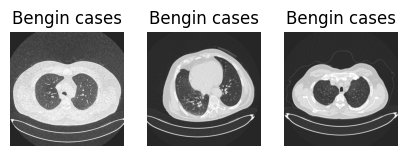

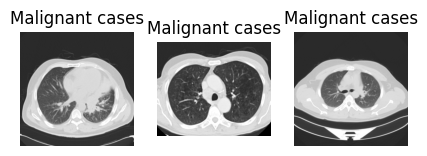

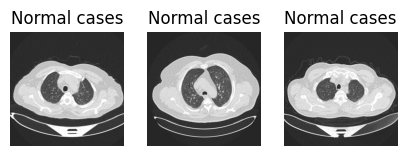

In [2]:
for category, group in df.groupby("label"):
    fig, ax = plt.subplots(1,3, figsize = (5,5))
    ax = ax.ravel()
    for i, (_,r) in enumerate(group.sample(3).iterrows()):
        img = cv2.imread(r.img_path)
        ax[i].imshow(img)
        ax[i].axis("off")
        ax[i].set_title(r.label)
    plt.show()

In [3]:
countData = df["label"].value_counts().reset_index()
countData.columns = ['label', 'count']
print(countData)
fig = px.histogram(data_frame = countData, x = "label", y = "count")
fig.show()

             label  count
0  Malignant cases    561
1     Normal cases    416
2     Bengin cases    120


In [4]:
import nbformat
print(nbformat.__version__)

5.10.4


In [5]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

2.19.0
3.9.2


In [6]:
sizes = []
resolutions = []
color_distrubtions = []

for img_path in df["img_path"]:
    img = cv2.imread(img_path)
    size = os.path.getsize(img_path)
    sizes.append(size)
    resolution = img.shape[:2]
    resolutions.append(resolution)
    mean_color_distrubtions = np.bincount(img.flatten(),minlength=256)
    color_distrubtions.append(mean_color_distrubtions)
sizes = np.array(sizes)
resolutions = np.array(resolutions)
mean_color_distrubtions = np.array(color_distrubtions)

In [7]:
sizes_MB = []
for img_path in df["img_path"]:
    img = cv2.imread(img_path)
    size = os.path.getsize(img_path)
    sizes_MB.append(size/1_000_000)

fig = px.histogram(x=sizes_MB, nbins=50, title="Distrubtion of image sizes")
fig.update_layout(xaxis_title = "File Size (MB)",
                  yaxis_title = "Number of Images",
                  showlegend = False,
                  bargap = 0.1,
                  bargroupgap = 0.1)
fig.update_traces(marker=dict(color="green"))
fig.show()

In [8]:
fig = px.scatter(x = resolutions[:,0], y=resolutions[:,1], title="Distribution of Image resolution")
fig.update_layout(
    xaxis_title="Width (Pixel)",
    yaxis_title="Height (Pixel)",
    showlegend = False,
    hovermode="closest"
)
fig.update_traces(marker=dict(color="red"))
fig.show()

In [9]:
mean_color_distrubtions = np.mean(color_distrubtions, axis = 0)
fig = go.Figure(
    go.Bar(x=np.arange(256), y=mean_color_distrubtions, name="Mean Color Distrubtions")
)
fig.update_layout(
    title="Mean Color Distrubtion",
    xaxis_title="Color Values",
    yaxis_title="Number of Pixel"
)
fig.show()

Train Test Split

In [10]:
train_ratio = 0.70
test_ratio = 0.15
val_ratio = 0.15

df_train, df_test_val = train_test_split(df, train_size = train_ratio, random_state = 42)
df_test, df_val = train_test_split(df_test_val, train_size = test_ratio/(test_ratio+val_ratio), random_state = 42)

print(f"Train shape = {df_train.shape}")
print(f"Test shape = {df_test.shape}")
print(f"Validation shape = {df_val.shape}")


Train shape = (767, 2)
Test shape = (165, 2)
Validation shape = (165, 2)


Denoise Image Using Median Blur

In [ ]:
def preprocessing_denoise(img):
    denoise_img = cv2.medianBlur(img, 1)
    denoise_img = cv2.cvtColor(denoise_img, cv2.COLOR_BGR2RGB)
    return denoise_img

In [69]:
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
def preprocessing_inception_v3(img):
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return inception_preprocess(rgb_img.astype(np.float32))

In [70]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
def preprocessing_vgg16(img):
    bgr_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return vgg_preprocess(bgr_img.astype(np.float32))

Image Data Augmentation using ImageDataGenerator

In [72]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
image_size = (IMG_WIDTH, IMG_HEIGHT)
batch_size = 32

# Augumentation for CNN model
TRAIN_DATAGEN = ImageDataGenerator(rescale=1./255.,
                                   preprocessing_function = preprocessing_denoise,
                                   rotation_range = 20,
                                   width_shift_range = 0.1, height_shift_range = 0.2,
                                   shear_range = 0.05, zoom_range = 0.1,
                                   horizontal_flip = True)
# Augumentation for InceptionV3 and VGG16 models
TRAIN_DATAGEN_INCEPTION = ImageDataGenerator(
                                rescale=1./255.,
                                preprocessing_function = preprocessing_inception_v3)
TRAIN_DATAGEN_VGG = ImageDataGenerator(
                                rescale=1./255.,
                                preprocessing_function = preprocessing_vgg16)

# Test and validation generators
TEST_DATAGEN = ImageDataGenerator(rescale=1./255.)
VAL_DATAGEN = ImageDataGenerator(rescale=1./255.,
                                 preprocessing_function = preprocessing_denoise)

    
# Generators(train and validation data) for InceptionV3 and VGG16
train_generator_inception= TRAIN_DATAGEN_INCEPTION.flow_from_dataframe(
    df_train, x_col = "img_path", y_col = "label",
    target_size = image_size, batch_size = batch_size,
    color_mode = "rgb", class_mode = "categorical",
    shuffle = True
)

val_generator_inception= TRAIN_DATAGEN_INCEPTION.flow_from_dataframe(
    df_val, x_col = "img_path", y_col = "label",
    target_size = image_size, batch_size = batch_size,
    color_mode = "rgb", class_mode = "categorical",
    shuffle = False
)

train_generator_vgg= TRAIN_DATAGEN_VGG.flow_from_dataframe(
    df_train, x_col = "img_path", y_col = "label",
    target_size = image_size, batch_size = batch_size,
    color_mode = "rgb", class_mode = "categorical",
    shuffle = True
)

val_generator_vgg= TRAIN_DATAGEN_VGG.flow_from_dataframe(
    df_val, x_col = "img_path", y_col = "label",
    target_size = image_size, batch_size = batch_size,
    color_mode = "rgb", class_mode = "categorical",
    shuffle = False
)

# Generators for test data
test_generator= TEST_DATAGEN.flow_from_dataframe(
    df_val, x_col = "img_path", y_col = "label",
    target_size = image_size, batch_size = batch_size,
    color_mode = "rgb", class_mode = "categorical",
    shuffle = False
)

Found 767 validated image filenames belonging to 3 classes.
Found 165 validated image filenames belonging to 3 classes.
Found 767 validated image filenames belonging to 3 classes.
Found 165 validated image filenames belonging to 3 classes.
Found 165 validated image filenames belonging to 3 classes.


Deep Learning model for classification

CNN

In [65]:
def create_model():
    model1 = Sequential([
        Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), input_shape = (224,224,3), activation = 'relu', padding = "same"),
        MaxPool2D(pool_size = (2,2)),
        BatchNormalization(),
        
        Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = "valid"),
        MaxPool2D(pool_size = (2,2)),
        BatchNormalization(),

        Conv2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = "valid"),
        MaxPool2D(pool_size = (2,2)),
        BatchNormalization(),

        Conv2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = "valid"),
        MaxPool2D(pool_size = (2,2)),
        BatchNormalization(),

        Conv2D(filters = 256, kernel_size = (3,3), strides = (1,1), padding = "valid"),
        MaxPool2D(pool_size = (2,2)),
        BatchNormalization(),

        Conv2D(filters = 256, kernel_size = (3,3), strides = (1,1), padding = "valid"),
        MaxPool2D(pool_size = (2,2)),
        BatchNormalization(),

        Flatten(),
        Dense(512, activation = "relu"),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.25),
        Dense(3, activation = "softmax")
        
    ])
    return model1

Training Model

Fold 1/5
Bengin cases: 3.19
Malignant cases: 0.66
Normal cases: 0.85
Found 613 validated image filenames belonging to 3 classes.
Found 154 validated image filenames belonging to 3 classes.


/Users/manitatamang/Desktop/dissertation/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/Users/manitatamang/Desktop/dissertation/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.3754 - loss: 1.4651 - val_accuracy: 0.5065 - val_loss: 1.0681 - learning_rate: 1.0000e-04
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5242 - loss: 1.0636 - val_accuracy: 0.5065 - val_loss: 1.0245 - learning_rate: 1.0000e-04
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5919 - loss: 0.9936 - val_accuracy: 0.5065 - val_loss: 1.0316 - learning_rate: 1.0000e-04
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5550 - loss: 0.9929 - val_accuracy: 0.5065 - val_loss: 1.1844 - learning_rate: 1.0000e-04
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6331 - loss: 0.8886 - val_accuracy: 0.5065 - val_loss: 1.3558 - learning_rate: 5.0000e-05
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.5706 - loss: 0.9603 - val_accuracy: 0.5065 - val_loss: 1.4272 - learning_rate: 5.0000e-05
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5796 - loss:

/Users/manitatamang/Desktop/dissertation/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/Users/manitatamang/Desktop/dissertation/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.4541 - loss: 1.2666 - val_accuracy: 0.5844 - val_loss: 1.0400 - learning_rate: 1.0000e-04
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.5095 - loss: 1.1554 - val_accuracy: 0.5065 - val_loss: 0.9994 - learning_rate: 1.0000e-04
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.5284 - loss: 1.0451 - val_accuracy: 0.5065 - val_loss: 1.0408 - learning_rate: 1.0000e-04
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6145 - loss: 0.9450 - val_accuracy: 0.5065 - val_loss: 1.0116 - learning_rate: 1.0000e-04
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6109 - loss: 0.9309 - val_accuracy: 0.5065 - val_loss: 1.0045 - learning_rate: 5.0000e-05
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.5828 - loss: 1.0316 - val_accuracy: 0.5065 - val_loss: 1.0087 - learning_rate: 5.0000e-05
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5406 - loss:

/Users/manitatamang/Desktop/dissertation/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/Users/manitatamang/Desktop/dissertation/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.3681 - loss: 1.2833 - val_accuracy: 0.5490 - val_loss: 1.0530 - learning_rate: 1.0000e-04
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.4910 - loss: 1.3166 - val_accuracy: 0.5098 - val_loss: 0.9995 - learning_rate: 1.0000e-04
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.5307 - loss: 1.0596 - val_accuracy: 0.5882 - val_loss: 0.9594 - learning_rate: 1.0000e-04
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.5582 - loss: 0.9490 - val_accuracy: 0.7059 - val_loss: 0.9112 - learning_rate: 1.0000e-04
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5819 - loss: 0.9187 - val_accuracy: 0.6013 - val_loss: 0.8980 - learning_rate: 1.0000e-04
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.5753 - loss: 0.9614 - val_accuracy: 0.5556 - val_loss: 0.9060 - learning_rate: 1.0000e-04
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.6244 - loss:

/Users/manitatamang/Desktop/dissertation/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/Users/manitatamang/Desktop/dissertation/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.4078 - loss: 1.2000 - val_accuracy: 0.5621 - val_loss: 1.0318 - learning_rate: 1.0000e-04
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.5540 - loss: 1.0140 - val_accuracy: 0.5033 - val_loss: 0.9571 - learning_rate: 1.0000e-04
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5775 - loss: 0.9567 - val_accuracy: 0.5033 - val_loss: 0.9615 - learning_rate: 1.0000e-04
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.5418 - loss: 0.9914 - val_accuracy: 0.5033 - val_loss: 1.0645 - learning_rate: 1.0000e-04
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.5726 - loss: 1.0115 - val_accuracy: 0.5033 - val_loss: 1.2017 - learning_rate: 5.0000e-05
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.5894 - loss: 0.8348 - val_accuracy: 0.5033 - val_loss: 1.3831 - learning_rate: 5.0000e-05
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.5993 - loss:

/Users/manitatamang/Desktop/dissertation/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/Users/manitatamang/Desktop/dissertation/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.3778 - loss: 1.3349 - val_accuracy: 0.6536 - val_loss: 1.0551 - learning_rate: 1.0000e-04
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.5246 - loss: 1.0971 - val_accuracy: 0.5033 - val_loss: 0.9820 - learning_rate: 1.0000e-04
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.5085 - loss: 1.2574 - val_accuracy: 0.5033 - val_loss: 0.9515 - learning_rate: 1.0000e-04
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.5592 - loss: 1.0159 - val_accuracy: 0.5033 - val_loss: 1.0328 - learning_rate: 1.0000e-04
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.5576 - loss: 0.9628 - val_accuracy: 0.5033 - val_loss: 1.0793 - learning_rate: 1.0000e-04
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.5909 - loss: 1.1000 - val_accuracy: 0.5033 - val_loss: 1.1284 - learning_rate: 5.0000e-05
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.5817 - loss:

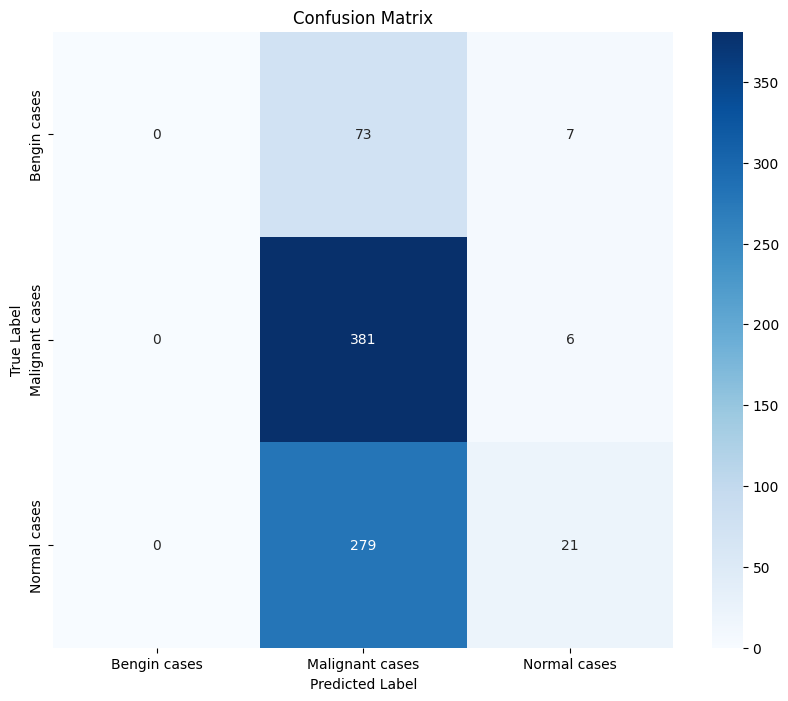

Classification Report:
                 precision    recall  f1-score   support

   Bengin cases       0.00      0.00      0.00        80
Malignant cases       0.52      0.98      0.68       387
   Normal cases       0.62      0.07      0.13       300

       accuracy                           0.52       767
      macro avg       0.38      0.35      0.27       767
   weighted avg       0.50      0.52      0.39       767



/Users/manitatamang/Desktop/dissertation/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/manitatamang/Desktop/dissertation/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/manitatamang/Desktop/dissertation/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [66]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

all_true_labels = []
all_pred_labels = []
fold_accuracies = []

NUM_FOLDS = 5
skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(df_train['img_path'], df_train['label'])):
    print(f"Fold {fold+1}/{NUM_FOLDS}")

    # Split data
    train_data = df_train.iloc[train_idx]
    val_data = df_train.iloc[val_idx]

    # Compute class weights
    labels = train_data['label'].values
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(labels),
        y=labels
    )
    train_class_weights = dict(enumerate(class_weights))

    # Display weights
    class_indices = {i: label for i, label in enumerate(np.unique(labels))}
    for idx, weight in train_class_weights.items():
        class_name = class_indices[idx]
        print(f"{class_name}: {weight:.2f}")

    # CNN data generators
    train_generator_cnn = TRAIN_DATAGEN.flow_from_dataframe(
        train_data, x_col="img_path", y_col="label",
        target_size=image_size, batch_size=batch_size,
        color_mode='rgb', class_mode="categorical",
        shuffle=True
    )

    val_generator_cnn = VAL_DATAGEN.flow_from_dataframe(
        val_data, x_col="img_path", y_col="label",
        target_size=image_size, batch_size=batch_size,
        color_mode="rgb", class_mode="categorical",
        shuffle=False
    )

    # Build and compile model
    model1 = create_model()
    model1.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(learning_rate=0.0001),
        metrics=['accuracy']
    )

    # Train
    history_cnn = model1.fit(
        train_generator_cnn,
        steps_per_epoch=len(train_generator_cnn),
        epochs=50,
        validation_data=val_generator_cnn,
        validation_steps=len(val_generator_cnn),
        class_weight=train_class_weights,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, mode='min')
        ]
    )

    # Save fold accuracy
    best_val_acc = max(history_cnn.history['val_accuracy'])
    fold_accuracies.append(best_val_acc)

    # Predict on validation data
    y_pred_probs = model1.predict(val_generator_cnn, verbose=1)
    y_pred_labels = np.argmax(y_pred_probs, axis=1)
    y_true_labels = val_generator_cnn.classes

    # Collect all predictions
    all_true_labels.extend(y_true_labels)
    all_pred_labels.extend(y_pred_labels)

# Final Evaluation
mean_accuracy = np.mean(fold_accuracies)
print(f"\nAverage Validation Accuracy across all folds: {mean_accuracy:.4f}")

# Confusion Matrix
class_names = [k for k, v in sorted(val_generator_cnn.class_indices.items(), key=lambda item: item[1])]
cm = confusion_matrix(all_true_labels, all_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("Classification Report:")
print(classification_report(all_true_labels, all_pred_labels, target_names=class_names))


Training Model InceptionV3

In [18]:
import certifi
print(certifi.where())

/Users/manitatamang/Desktop/dissertation/.venv/lib/python3.11/site-packages/certifi/cacert.pem


In [74]:
from tensorflow.keras.applications import InceptionV3, VGG16
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

base_model = InceptionV3(input_shape = (IMG_WIDTH, IMG_HEIGHT, 3), include_top = False, weights = "imagenet")

for layer in base_model.layers:
    layer.trainable = False

model2 = Sequential()
model2.add(Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model2.add(base_model)
model2.add(Flatten())
model2.add(Dense(1024, activation="relu"))
model2.add(Dropout(0.4))
model2.add(Dense(3, activation="softmax"))

epochs = 50
model2.compile(optimizer = Adam(0.0005),
               loss = "categorical_crossentropy",
               metrics = ["accuracy"])
    
history_inception = model2.fit(train_generator_inception,
                     steps_per_epoch = len(train_generator_inception),
                     batch_size = 64,
                     validation_data = val_generator_inception, validation_steps = len(val_generator_inception),
                     class_weight = train_class_weights,
                     callbacks = [
                         EarlyStopping(monitor = "val_loss",
                                       patience = 5,
                                       restore_best_weights = True),
                                       ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, mode='min')
                     ],
                     epochs = epochs)

y_pred_probs = model2.predict(val_generator_inception, verbose=1)
y_pred_labels = np.argmax(y_pred_probs, axis = 1)
y_true_labels = val_generator_inception.classes

print(classification_report(y_true_labels, y_pred_labels))
print(confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels))

/Users/manitatamang/Desktop/dissertation/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.4601 - loss: 6.7565 - val_accuracy: 0.7939 - val_loss: 0.7220 - learning_rate: 5.0000e-04
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7235 - loss: 1.5369 - val_accuracy: 0.6182 - val_loss: 1.4116 - learning_rate: 5.0000e-04
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7355 - loss: 1.1076 - val_accuracy: 0.6485 - val_loss: 1.0008 - learning_rate: 5.0000e-04
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7827 - loss: 0.6263 - val_accuracy: 0.9273 - val_loss: 0.2213 - learning_rate: 1.0000e-04
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9185 - loss: 0.2115 - val_accuracy: 0.9394 - val_loss: 0.2083 - learning_rate: 1.0000e-04
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9469 - loss: 0.1862 - val_accuracy: 0.9273 - val_loss: 0.2240 - learning_rate: 1.0000e-04
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9486 - loss:

Fine-tune InceptionV3

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.9989 - loss: 0.0095 - val_accuracy: 0.9636 - val_loss: 0.2806 - learning_rate: 1.0000e-05
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9944 - loss: 0.0261 - val_accuracy: 0.9576 - val_loss: 0.2070 - learning_rate: 1.0000e-05
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.9942 - loss: 0.0318 - val_accuracy: 0.9515 - val_loss: 0.2747 - learning_rate: 1.0000e-05
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.9961 - loss: 0.0084 - val_accuracy: 0.9697 - val_loss: 0.2292 - learning_rate: 1.0000e-05
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9968 - loss: 0.0137 - val_accuracy: 0.9697 - val_loss: 0.2070 - learning_rate: 2.0000e-06
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9981 - loss: 0.0056 - val_accuracy: 0.9697 - val_loss: 0.2024 - learning_rate: 2.0000e-06
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 1.0000 - loss:

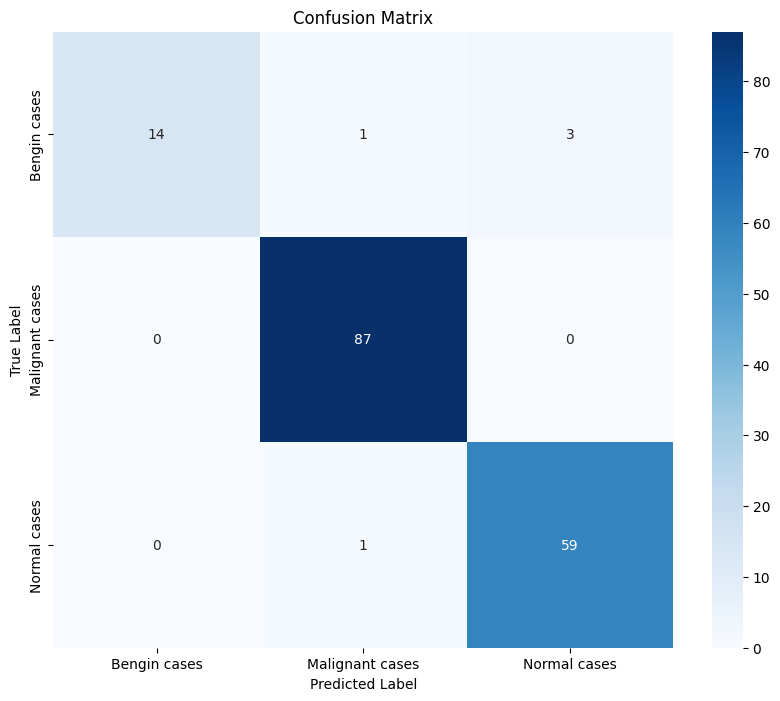

Classification Report:
                 precision    recall  f1-score   support

   Bengin cases       1.00      0.78      0.88        18
Malignant cases       0.98      1.00      0.99        87
   Normal cases       0.95      0.98      0.97        60

       accuracy                           0.97       165
      macro avg       0.98      0.92      0.94       165
   weighted avg       0.97      0.97      0.97       165



In [97]:
set_trainable = False
for layer in base_model.layers:
    if layer.name == 'mixed7':
        set_trainable = True
    layer.trainable = set_trainable

model2.compile(optimizer=Adam(0.00001),
               loss = "categorical_crossentropy",
               metrics = ["accuracy"])

epochs = 50
history = model2.fit(train_generator_inception,
                     steps_per_epoch = len(train_generator_inception),
                     batch_size = 64,
                     validation_data = val_generator_inception,
                     validation_steps = len(val_generator_inception),
                     class_weight = train_class_weights,
                     callbacks = [
                         EarlyStopping(monitor="val_loss",
                         patience = 5,
                         restore_best_weights = True),
                         ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, mode="min")
                     ],
                     epochs = epochs)

all_true_labels = []
all_pred_labels = []

# Collect all the true and predicted labels
for i in range(len(val_generator_inception)):
    batch = val_generator_inception[i]
    images, labels = batch
    predictions = model2.predict(images)
    
    all_true_labels.extend(np.argmax(labels, axis=1))
    all_pred_labels.extend(np.argmax(predictions, axis=1))

# Confusion Matrix
class_names = [k for k, v in sorted(val_generator_inception.class_indices.items(), key=lambda item: item[1])]
cm = confusion_matrix(all_true_labels, all_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("Classification Report:")
print(classification_report(all_true_labels, all_pred_labels, target_names=class_names))


In [98]:
test_loss, test_accuracy = model2.evaluate(test_generator, steps=len(test_generator))
print(f"test loss: {test_loss:.4f}, test accuracy: {test_accuracy:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 593ms/step - accuracy: 0.5569 - loss: 22.4321
test loss: 23.7667, test accuracy: 0.5273


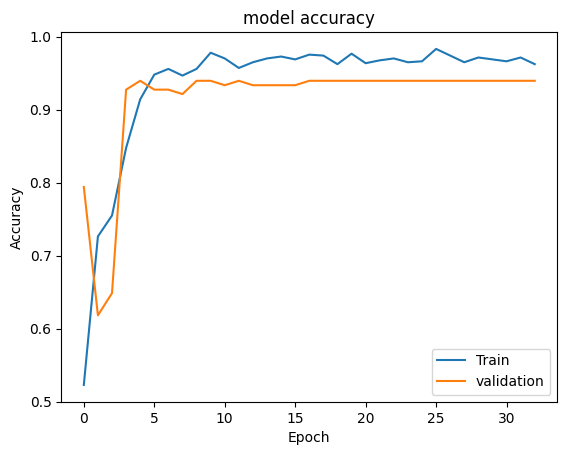

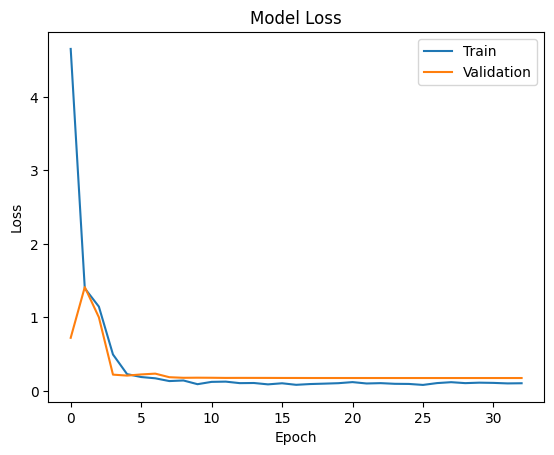

In [76]:
plt.plot(history_inception.history['accuracy'], label='Train')
plt.plot(history_inception.history['val_accuracy'], label='validation')
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history_inception.history['loss'], label='Train')
plt.plot(history_inception.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

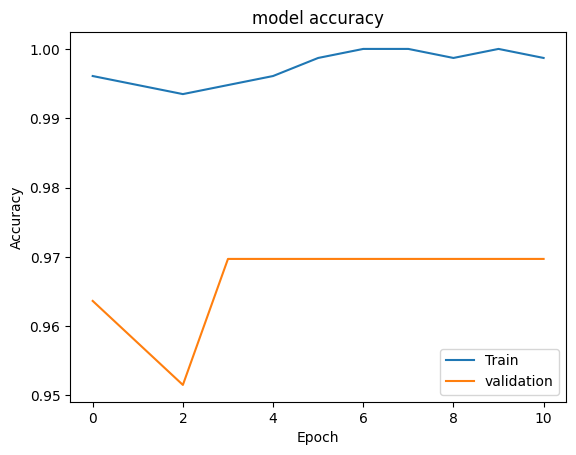

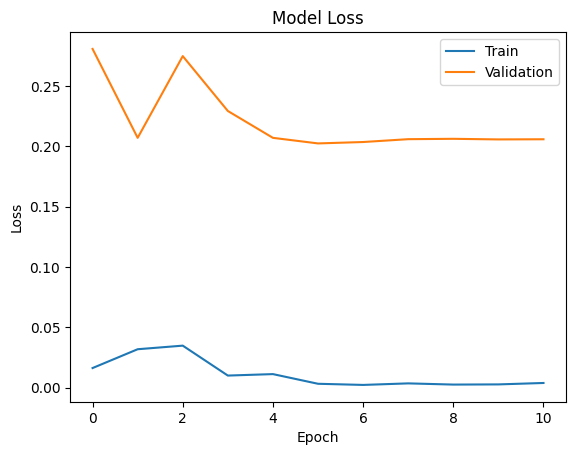

In [99]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# Save InceptionV3 Model
# model2.save('inception_model.h5')

Training Model VGG16

In [78]:
base_model_vgg16 = VGG16(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), include_top=False, weights="imagenet")
for layer in base_model_vgg16.layers:
    layer.trainable = False

model3 = Sequential()
model3.add(Input(shape = (IMG_WIDTH, IMG_HEIGHT, 3)))
model3.add(base_model_vgg16)
model3.add(Flatten())
model3.add(Dense(1024, activation="relu"))
model3.add(Dropout(0.4))
model3.add(Dense(3, activation="softmax"))

model3.compile(optimizer = Adam(0.0005),
               loss = "categorical_crossentropy",
               metrics = ["accuracy"])

epochs = 50
history_vgg = model3.fit(train_generator_vgg,
                     steps_per_epoch = len(train_generator_vgg),
                     batch_size = 64,
                     validation_data = val_generator_vgg, 
                     validation_steps = len(val_generator_vgg),
                     class_weight = train_class_weights,
                     callbacks = [
                         EarlyStopping(monitor="val_loss",
                         patience = 5,
                         restore_best_weights = True),
                         ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, mode='min')
                     ],
                     epochs = epochs)

y_pred_probs = model3.predict(val_generator_vgg, verbose=1)
y_pred_labels = np.argmax(y_pred_probs, axis = 1)
y_true_labels = val_generator_vgg.classes

print(classification_report(y_true_labels, y_pred_labels))
print(confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels))

/Users/manitatamang/Desktop/dissertation/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 153s 6s/step - accuracy: 0.4441 - loss: 3.9463 - val_accuracy: 0.7636 - val_loss: 0.6393 - learning_rate: 5.0000e-04
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - accuracy: 0.7811 - loss: 0.6793 - val_accuracy: 0.9333 - val_loss: 0.1846 - learning_rate: 5.0000e-04
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 143s 6s/step - accuracy: 0.9077 - loss: 0.2608 - val_accuracy: 0.9576 - val_loss: 0.1018 - learning_rate: 5.0000e-04
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 137s 6s/step - accuracy: 0.9532 - loss: 0.1515 - val_accuracy: 0.9152 - val_loss: 0.2317 - learning_rate: 5.0000e-04
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 130s 5s/step - accuracy: 0.9437 - loss: 0.1578 - val_accuracy: 0.9455 - val_loss: 0.1691 - learning_rate: 5.0000e-04
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 157s 7s/step - accuracy: 0.9489 - loss: 0.1240 - val_accuracy: 0.9818 - val_loss: 0.0713 - learning_rate: 1.0000e-04
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 147s 6s/step - accuracy: 0.9799 

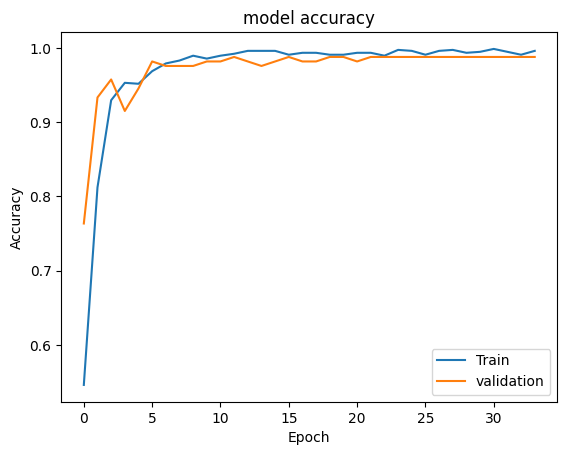

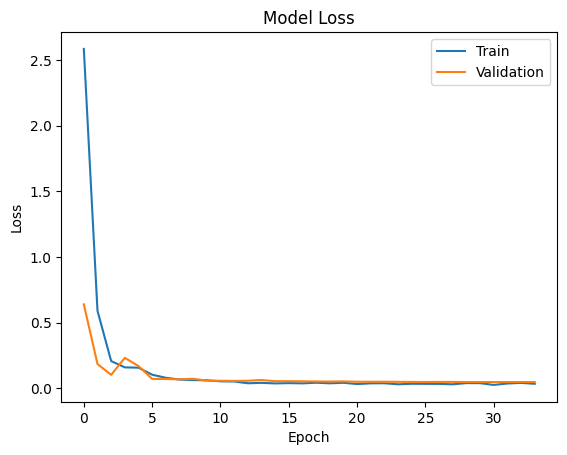

In [79]:
plt.plot(history_vgg.history['accuracy'], label='Train')
plt.plot(history_vgg.history['val_accuracy'], label='validation')
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history_vgg.history['loss'], label='Train')
plt.plot(history_vgg.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Fine Tuning VGG16 Model

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 140s 6s/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9758 - val_loss: 0.0616 - learning_rate: 1.0000e-05
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9818 - val_loss: 0.0531 - learning_rate: 1.0000e-05
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - accuracy: 1.0000 - loss: 8.0925e-04 - val_accuracy: 0.9939 - val_loss: 0.0189 - learning_rate: 1.0000e-05
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 143s 6s/step - accuracy: 1.0000 - loss: 5.3464e-04 - val_accuracy: 0.9879 - val_loss: 0.0359 - learning_rate: 1.0000e-05
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 144s 6s/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9758 - val_loss: 0.0715 - learning_rate: 1.0000e-05
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 152s 6s/step - accuracy: 1.0000 - loss: 8.0415e-04 - val_accuracy: 0.9879 - val_loss: 0.0358 - learning_rate: 2.0000e-06
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 145s 6s/step - accur

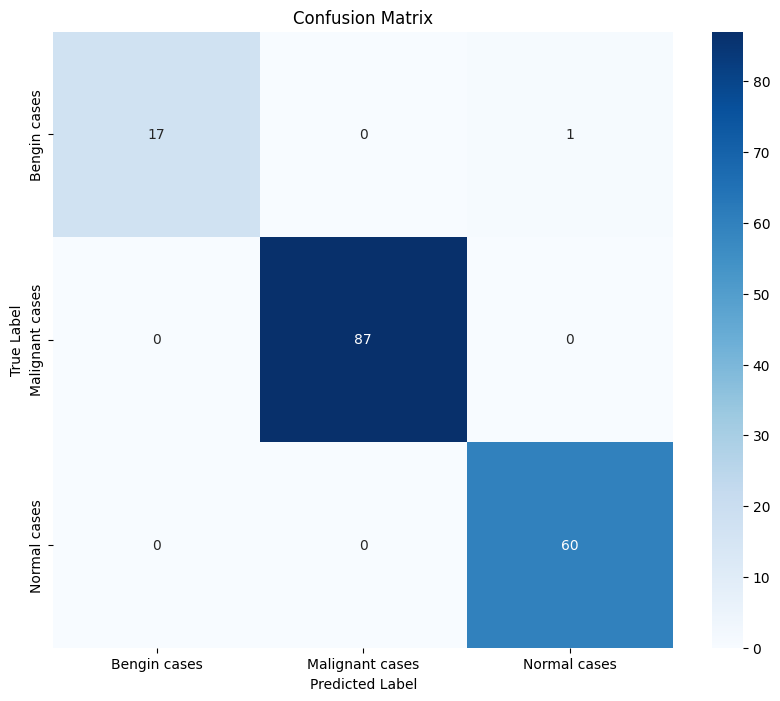

Classification Report:
                 precision    recall  f1-score   support

   Bengin cases       1.00      0.94      0.97        18
Malignant cases       1.00      1.00      1.00        87
   Normal cases       0.98      1.00      0.99        60

       accuracy                           0.99       165
      macro avg       0.99      0.98      0.99       165
   weighted avg       0.99      0.99      0.99       165



In [85]:
base_model_vgg16.trainable = True
set_trainable = False
for layer in base_model_vgg16.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model3.compile(optimizer=Adam(0.00001),
               loss = "categorical_crossentropy",
               metrics = ["accuracy"])

epochs = 50
history = model3.fit(train_generator_vgg,
                     steps_per_epoch = len(train_generator_vgg),
                     batch_size = 64,
                     validation_data = val_generator_vgg,
                     validation_steps = len(val_generator_vgg),
                     class_weight = train_class_weights,
                     callbacks = [
                         EarlyStopping(monitor="val_loss",
                         patience = 5,
                         restore_best_weights = True),
                         ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, mode="min")
                     ],
                     epochs = epochs)

all_true_labels = []
all_pred_labels = []

# Collect all the true and predicted labels
for i in range(len(val_generator_vgg)):
    batch = val_generator_vgg[i]
    images, labels = batch
    predictions = model3.predict(images)
    
    all_true_labels.extend(np.argmax(labels, axis=1))
    all_pred_labels.extend(np.argmax(predictions, axis=1))

# Confusion Matrix
class_names = [k for k, v in sorted(val_generator_vgg.class_indices.items(), key=lambda item: item[1])]
cm = confusion_matrix(all_true_labels, all_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("Classification Report:")
print(classification_report(all_true_labels, all_pred_labels, target_names=class_names))

In [89]:
test_loss, test_accuracy = model3.evaluate(test_generator, steps=len(test_generator))
print(f"test loss: {test_loss:.4f}, test accuracy: {test_accuracy:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.9948 - loss: 0.0185
test loss: 0.0221, test accuracy: 0.9939


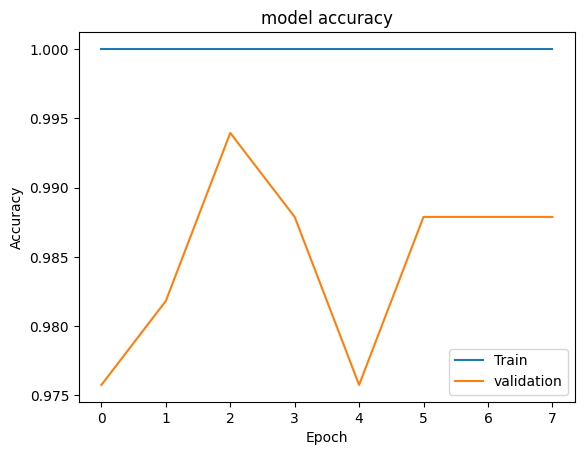

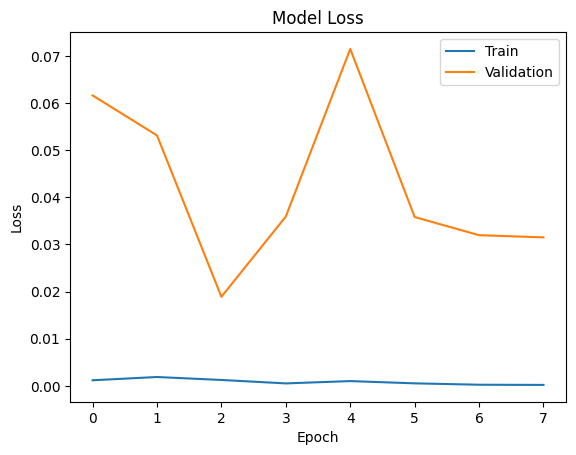

In [86]:
# Fine-tuned model
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# Save VGG16 Model
# model3.save('vgg_model.h5')

In [93]:
models = [model1, model2, model3]
loss = []
accuracy = []
for model in models:
    results = model.evaluate(test_generator, verbose = 0)
    loss.append(results[0])
    accuracy.append(results[1])

name_models = ["CNN (Custom)", "InceptionV3", "VGG16"]
df_loss_acc = pd.DataFrame(data = {"Name_Models" : name_models,
                                  "Loss" : loss,
                                  "Accuracy" : accuracy})

fig = px.bar(data_frame = df_loss_acc, x = "Name_Models", y = ["Accuracy", "Loss"],
            barmode = "group",
            text_auto = ".3f")
fig.show()

Prognosis Models

Support Vector Machine (SVM)

In [5]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

risk_map = {'Malignant cases': 2, 'Bengin cases': 1, 'Normal cases': 0}
df['risk_score'] = df['label'].map(risk_map)

# VGG16 model for feature extraction
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=base_model.output)

def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    print(f"Shape of features before flattening: {features.shape}")
    flattend_features = features.flatten()
    return flattend_features

# Extract features
df['features'] = list(map(extract_features, df['img_path']))

# Prepare data for regression
X = np.stack(df['features'].values)
print(f"Shape of feature matrix X: {X.shape}")
y = df['risk_score'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Regression model (Ridge)
svm_model = Ridge()
svm_model.fit(X_train, y_train)

# Predict & evaluate
y_pred = svm_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"\n Mean Squared Error: {mse:.4f}")
r2 = r2_score(y_test, y_pred)
print(f"\n R2 Score: {mse:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
Shape of features before flattening: (1, 7, 7, 512)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Shape of features before flattening: (1, 7, 7, 512)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Shape of features before flattening: (1, 7, 7, 512)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Shape of features before flattening: (1, 7, 7, 512)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Shape of features before flattening: (1, 7, 7, 512)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Shape of features before flattening: (1, 7, 7, 512)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Shape of features before flattening: (1, 7, 7, 512)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Shape of features before flattening: (1, 7, 7, 512)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Shape of features before flattening: (1, 7, 7, 512)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Shape of features before flattening: (1, 7, 7, 512)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Shape of features before flattening: (1, 7, 7, 512)

/Users/manitatamang/Desktop/dissertation/.venv/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


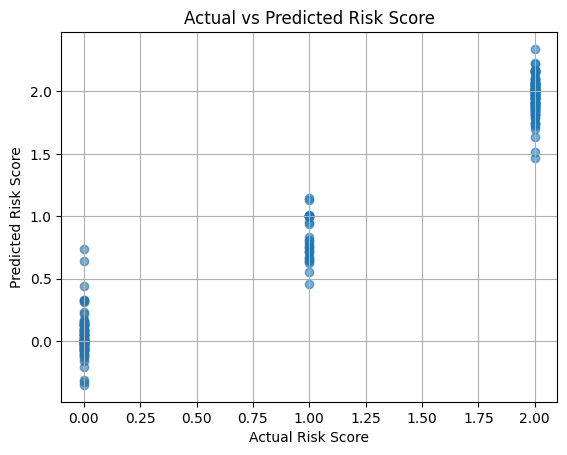

In [113]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Risk Score")
plt.ylabel("Predicted Risk Score")
plt.title("Actual vs Predicted Risk Score")
plt.grid(True)
plt.show()

In [ ]:
# Save the trained models
# import joblib
# joblib.dump(svm_model, 'svm_model.pkl')
# print('Models have been saved successfully')

Models have been saved successfully
